In [1]:
import os

import numpy as np
import pandas as pd
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm

In [2]:
# Root directory for the dataset
root = "data/DressCode/"

# Map labels to their corresponding directories
DIRECTORY_MAP = ["upper_body", "lower_body", "dresses"]

In [3]:
# Read in the dataset
test_pairs = pd.read_csv(
    os.path.join(root, "test_pairs_paired_cropped.txt"),
    delimiter="\t",
    header=None,
    names=["model", "garment", "label"],
)

test_pairs.head()

,model,garment,label
0,048392_0.jpg,048392_1.jpg,0
1,048393_0.jpg,048393_1.jpg,0
2,048394_0.jpg,048394_1.jpg,0
3,048395_0.jpg,048395_1.jpg,0
4,048396_0.jpg,048396_1.jpg,0


In [4]:
# Set the seed
torch.manual_seed(42)

# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [5]:
# Load in the encoder network
encoder = models.resnet50()

# Load the weights
encoder.load_state_dict(torch.load("models/ResNet50.pt"))

# Send the model to the device
encoder = encoder.to(device)

# Define the transformations for the network
transforms = transforms.Compose([transforms.Resize((256, 192)), transforms.ToTensor()])

In [6]:
# NUM_IMAGES x NUM_FEATURES
features = np.zeros((len(test_pairs), 1000))

encoder.eval()

with torch.no_grad():
    for i, (model, garment, label) in tqdm(
        enumerate(test_pairs.values),
        desc="Calculating Features",
        total=len(test_pairs),
        unit="image",
    ):
        # Load in the garment image
        garment_image = Image.open(
            os.path.join(root, DIRECTORY_MAP[label], "cropped_images", garment)
        ).convert("RGB")

        # Resize & convert to tensor
        garment_image = transforms(garment_image)

        # Add a batch dimension
        garment_image = garment_image.unsqueeze(0).to(device)

        # Get the features
        features[i] = encoder(garment_image).cpu().numpy()

Calculating Features: 100%|██████████| 5379/5379 [02:08<00:00, 41.84image/s] 


In [7]:
def get_features(image: Image) -> np.ndarray:
    """
    Get the features for a given image.
    """
    # Set the model to evaluation mode
    encoder.eval()

    # Resize & convert to tensor
    image = transforms(image)

    # Add a batch dimension
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        return encoder(image).cpu().numpy()

In [23]:
j = 0

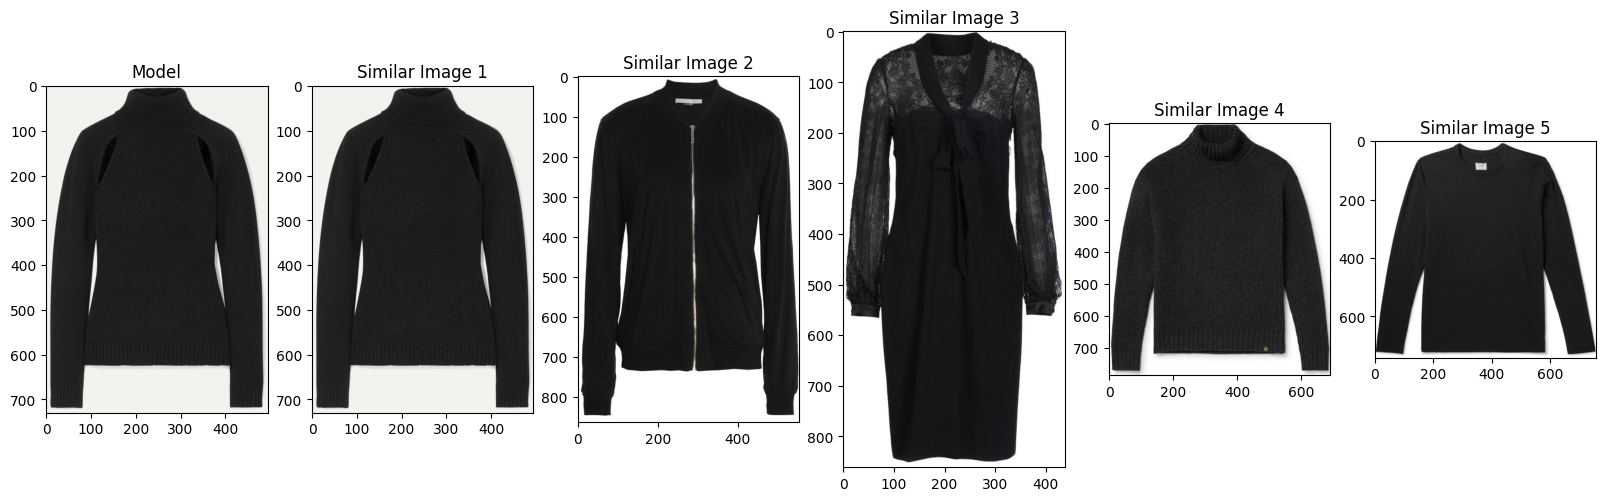

In [59]:
model, garment, label = test_pairs.values[j]

model_image = Image.open(
    os.path.join(root, DIRECTORY_MAP[label], "cropped_images", garment)
).convert("RGB")

model_features = get_features(model_image)

# Calculate the cosine similarity between the model image and all other images
distances = np.linalg.norm(features - model_features, axis=1)

# Find the 5 most similar images
similar_image_indices = np.argsort(distances)[:5]

# Display the images
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 6, figsize=(20, 10))

# Display the model image

axs[0].imshow(model_image)
axs[0].set_title("Model")

for i, idx in enumerate(similar_image_indices, 1):
    image = Image.open(
        os.path.join(
            root,
            DIRECTORY_MAP[test_pairs.iloc[idx]["label"]],
            "cropped_images",
            test_pairs.iloc[idx]["garment"],
        )
    ).convert("RGB")
    axs[i].imshow(image)
    axs[i].set_title(f"Similar Image {i}")

plt.show()

j += 1